In [1]:
#%pip install protobuf==3.20.1

%pip install -U sentence-transformers
%pip install umap-learn


In [8]:
QPATH = "Quantlet/EDA_and_script_similarity"
PATH = f'/content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/{QPATH}'

In [9]:
import sys
IN_COLAB = 'google.colab' in sys.modules

import os
if IN_COLAB:
  os.chdir(PATH)

sys.path.append('../src')

In [10]:
import pickle
import json
import re
import sys
from IPython.display import display

from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import nltk
nltk.download('punkt')

import importlib
import preprocessing_utils
importlib.reload(preprocessing_utils)

from sentence_transformers import SentenceTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

from scipy import stats
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [92]:
with open('../../data/preprocessed/Quantlet/Parsed_Qs_with_code_25062023.pkl', 'rb') as file:
  df = pickle.load(file)

CLEAN_UP = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [93]:
RS = 1
N_NEIGHB = 10
MIN_DIST = 0.25

In [94]:
df = df[df.metainfo_file!='empty']
print(df.shape)

(4856, 6)


In [95]:
def parse_meta(row):
    row = row['metainfo_file']
    if row=='empty':
        return ['','','','']
    dict_keys = list(row.keys())
    dict_key_n = [k.lower() for k in dict_keys]
    name_idx = np.where(['name' in k for k in dict_key_n])[0]
    desc_idx = np.where(['desc' in k for k in dict_key_n])[0]
    key_idx = np.where(['keyw' in k for k in dict_key_n])[0]
    auth_idx = np.where(['auth' in k for k in dict_key_n])[0]

    dict_keys_used = []

    if len(name_idx) > 0:
        name = row[dict_keys[name_idx[0]]]
        dict_keys_used.append(name)
    else:
        name = ''
    if len(desc_idx) > 0:
        desc = row[dict_keys[desc_idx[0]]]
        dict_keys_used.append(desc)
    else:
        desc = ''
    if len(key_idx) > 0:
        key = row[dict_keys[key_idx[0]]]
        dict_keys_used.append(key)
    else:
        key = ''

    if len(auth_idx) > 0:
        aut = row[dict_keys[auth_idx[0]]]
        dict_keys_used.append(aut)
    else:
        aut = ''

    other = {k: row[k] for k in dict_keys if k not in dict_keys_used}
    return [name, desc, key, aut, other]

In [96]:
# Parse metainfo file
if 'Keywords' not in df.columns:
  meta_info = pd.DataFrame(columns=['Quantlet', 'Description', 'Keywords', 'Other'])

  meta_info[['Quantlet', 'Description', 'Keywords', 'Authors', 'Other']] = df.apply(
      lambda x: parse_meta(x),
      axis='columns',
      result_type='expand'
      )

  for col in meta_info.columns:
      meta_info[col] = meta_info[col].astype(str)

  df = pd.concat([df, meta_info], axis=1)

  del df['metainfo_file']
  del df['Other']
  del df['script_name']
  del df['script_name_no_ext']

In [97]:
df['multiple_scripts'] = df['code_script'].apply(lambda x: any(isinstance(i, list) for i in x))
df['code_script_joined'] = ''
df.loc[df['multiple_scripts']==True, 'code_script_joined'] = df.loc[df['multiple_scripts']==True, 'code_script'].apply(lambda x: [''.join(code_script) for code_script in x])
df.loc[df['multiple_scripts']!=True, 'code_script_joined'] = df.loc[df['multiple_scripts']!=True, 'code_script'].apply(lambda x: [''.join(x)])
df['scr_n'] = df['code_script_joined'].apply(len)

In [99]:
# Create one dataset, each script separate, with the same description and keywords

df_long = df.explode('code_script_joined')
# Create one dataset, one metainfo file, all scripts together


In [100]:
def explode_code_and_lang(df):
    new_df = pd.DataFrame()

    print(f'Shape before exploding scripts: {df.shape}')

    for index, row in tqdm(df.iterrows()):
        if row['multiple_scripts']==True:
          for i, script in enumerate(row['code_script']):
              row['main_script'] = script
              row['main_type_script'] = row['type_script'][i]
              new_df = new_df.append(row)
        else:
          new_df = new_df.append(row)

    new_df['main_script'] = new_df['main_script'].fillna(new_df['code_script'])
    new_df['main_type_script'] = new_df['main_type_script'].fillna(new_df['type_script'])

    new_df = new_df.reset_index(drop=True)
    print(f'Shape after exploding scripts: {new_df.shape}')
    return new_df

df_long = explode_code_and_lang(df)

df_long['code_script'] = df_long['main_script'].progress_apply(lambda x: ''.join(x) if len(x)>0 else np.nan)
df_long['type_script'] = df_long['main_type_script']

del df_long['main_type_script']
del df_long['main_script']
del df_long['code_script_joined']

Shape before exploding scripts: (4856, 10)


4856it [00:22, 220.67it/s]


Shape after exploding scripts: (6743, 12)


100%|██████████| 6743/6743 [00:00<00:00, 116311.99it/s]


In [101]:
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

In [102]:
df_deduplicated = df_long.drop_duplicates(subset=['folder_name', 'code_script'])
df_deduplicated = df_deduplicated.reset_index(drop=True)

df_deduplicated['repo'] = df_deduplicated['folder_name'].apply(lambda x: re.sub(r'.+(data\/QuantLet\/)([^\/]+)(\/).+', r'\2' , x))
df_deduplicated['repo'] = df_deduplicated['repo'].apply(lambda x: re.sub(r'.+(data\/QuantLet\/)([^\/]+)', r'\2' , x))
print(df_deduplicated.shape)

sample_repos = df_deduplicated['repo'].drop_duplicates().sample(35, random_state=42).unique()
df_sample = df_deduplicated[df_deduplicated.repo.isin(sample_repos)].reset_index(drop=True)

(4857, 10)


In [103]:

le = preprocessing.LabelEncoder()
df_sample['repos_id'] = le.fit_transform(df_sample['repo'])

In [227]:
embeddings_df = df_sample.code_script.progress_apply(lambda x: model.encode(x))

embeddings = np.stack(embeddings_df.values)

100%|██████████| 310/310 [00:36<00:00,  8.51it/s]


In [105]:
#!mkdir images

In [229]:
sim_m_full = cosine_similarity(embeddings)
np.fill_diagonal(sim_m_full, 0)
sim_m_df = pd.DataFrame(sim_m_full)

In [246]:
sample_ov = sim_m_df.mean().mean()

In [228]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=N_NEIGHB,
                      n_components=2,
                      min_dist=MIN_DIST,
                      metric='cosine',
                      random_state=RS).fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = df_sample['repos_id']
#result.to_csv('umap_reduced_data.csv', index=False)


(-10.0, 10.0)

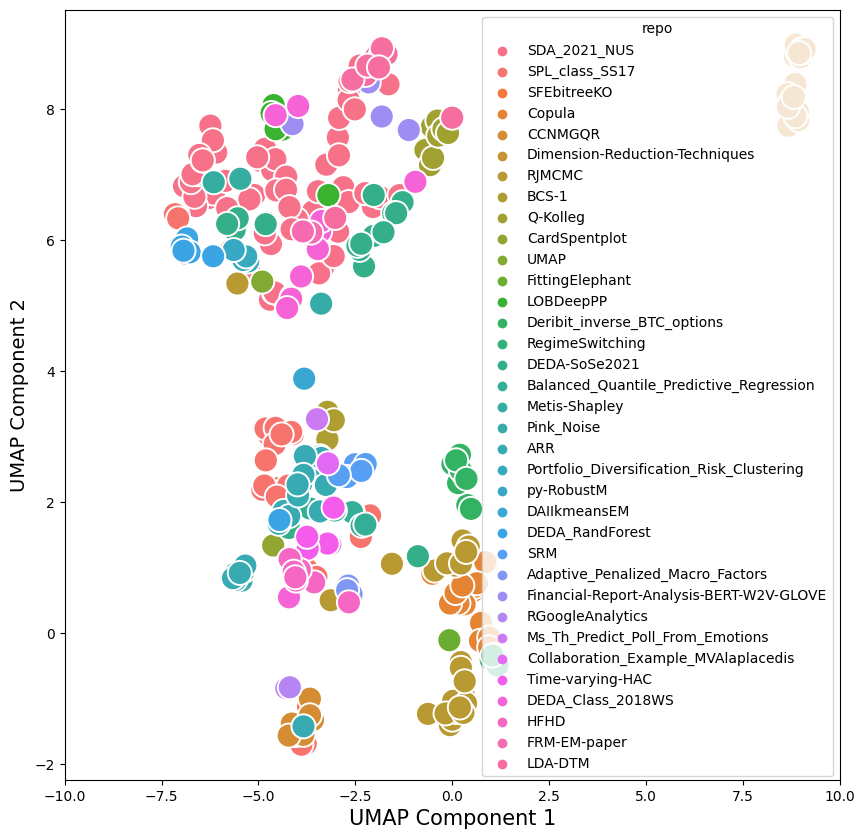

In [107]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=result.x, y=result.y, hue=df_sample['repo'], s=300)
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.xlim((-10, 10))
#plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim_with_legend.png", transparent=True)
#plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim_with_legend.pdf", format='pdf', transparent=True)

(-10.0, 10.0)

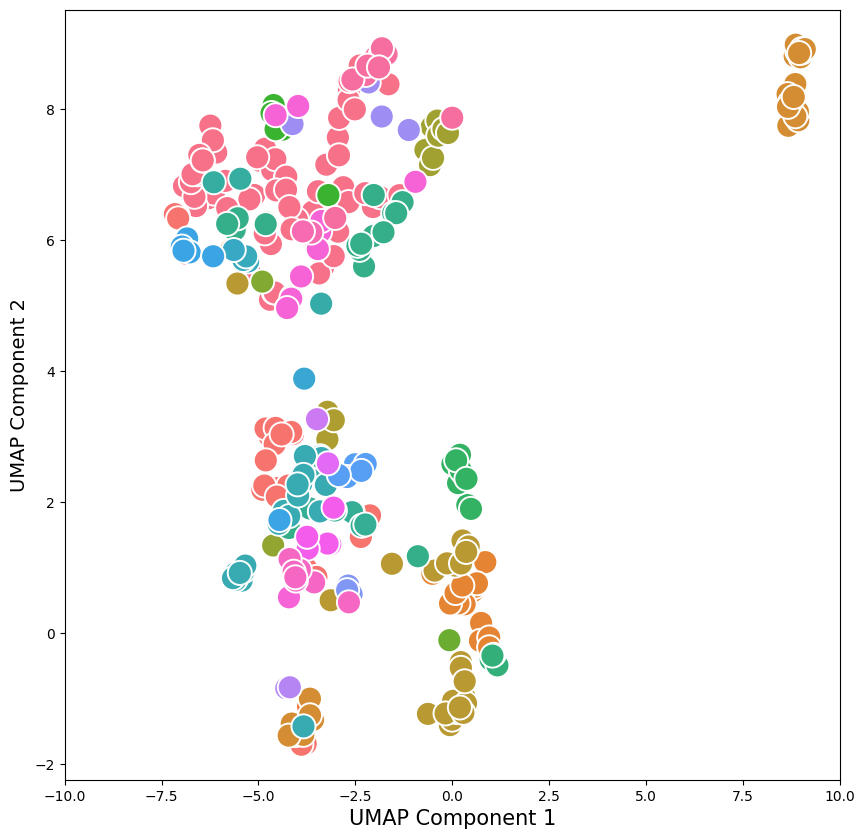

In [108]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=result.x, y=result.y, hue=df_sample['repo'], legend=False, s=300)
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.xlim((-10, 10))
#plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim.png", transparent=True)
#plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim.pdf", format='pdf', transparent=True)

In [232]:
ORS_sample = []
for i, row in tqdm(df_sample.iterrows()):
    repo = row['repo']
    idx_out = df_sample[df_sample.repo!=repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_out].mean()
    ORS_sample.append(dtemp)


IRS_sample = []
for i, row in tqdm(df_sample.iterrows()):
    repo = row['repo']
    idx_in = df_sample[df_sample.repo==repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_in].mean()
    IRS_sample.append(dtemp)

310it [00:00, 1000.50it/s]
310it [00:00, 1031.58it/s]


In [243]:
IRS_df = pd.DataFrame(data={'Similarity' : np.array(IRS_sample), 'Type': 'IRS'})
ORS_df = pd.DataFrame(data={'Similarity' : np.array(ORS_sample), 'Type': 'ORS'})

dist_df = pd.concat([IRS_df, ORS_df], axis=0)

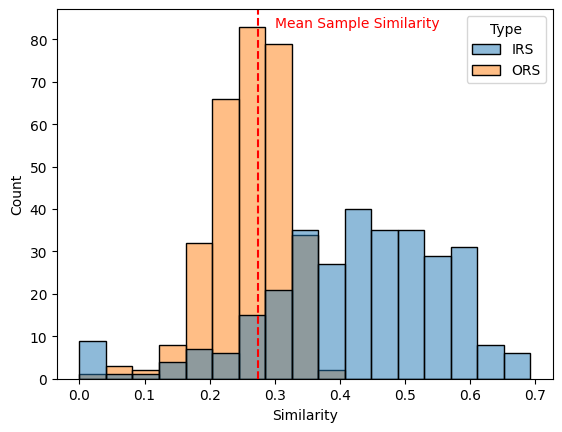

In [273]:
ax = sns.histplot(data=dist_df, x="Similarity", hue="Type")
plt.axvline(x=sample_ov, linestyle='--', c='red')
#plt.legend(["red dotted line"], handlelength=3)
ax.text(0.3, 83, "Mean Sample Similarity", c='red')
plt.savefig(f"{PATH}/images/similarity_distribution.pdf", format='pdf', transparent=True)

In [111]:
df_deduplicated['repos_id'] = le.fit_transform(df_deduplicated['repo'])
df_deduplicated['auth_id']  = le.fit_transform(df_deduplicated['Authors'])
df_deduplicated= df_deduplicated[df_deduplicated.code_script.notna()]
df_deduplicated = df_deduplicated.reset_index(drop=True)

embeddings_df_full = df_deduplicated.code_script.progress_apply(lambda x: model.encode(x))
embeddings = np.stack(embeddings_df_full.values)

#with open("embed.pkl", "wb") as file:
#  pickle.dump(embeddings, file)

In [137]:
sim_m_full = cosine_similarity(embeddings)
np.fill_diagonal(sim_m_full, 0)
sim_m_df = pd.DataFrame(sim_m_full)
overall_similarity_mean = (sim_m_df).mean().mean()

In [171]:
inter_repo_distance = []
for i, row in tqdm(df_deduplicated.iterrows()):
    repo = row['repo']
    idx_out = df_deduplicated[df_deduplicated.repo!=repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_out].mean()
    inter_repo_distance.append(dtemp)

intra_repo_distance_code_lev = []
for i, row in tqdm(df_deduplicated.iterrows()):
    repo = row['repo']
    idx_in = df_deduplicated[df_deduplicated.repo==repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_in].mean()
    intra_repo_distance_code_lev.append(dtemp)

In [180]:
indices = range(len(intra_repo_distance_code_lev))
random_idx = random.sample(indices, 50)
#with open("random_idx.pkl", "wb") as file:
#  pickle.dump(random_idx, file)

In [187]:
IRS_distances_sample = [dist for i, dist in enumerate(intra_repo_distance_code_lev) if i in random_idx]
ORS_distances_sample = [dist for i, dist in enumerate(inter_repo_distance) if i in random_idx]
difference = np.array(IRS_distances_sample) - np.array(ORS_distances_sample)

In [193]:
stats.normaltest(difference)

NormaltestResult(statistic=17.250908690707448, pvalue=0.00017947864161125724)

In [201]:
stats.wilcoxon(difference, alternative='greater')

WilcoxonResult(statistic=1273.0, pvalue=2.6645352591003757e-15)

In [218]:
diff_author_distance = []
for i, row in tqdm(df_deduplicated.iterrows()):
    repo = row['Authors']
    idx_out = df_deduplicated[df_deduplicated.Authors!=repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_out].mean()
    diff_author_distance.append(dtemp)

same_author_distance = []
for i, row in tqdm(df_deduplicated.iterrows()):
    repo = row['Authors']
    idx_in = df_deduplicated[df_deduplicated.Authors==repo].index.tolist()
    dtemp = sim_m_df.iloc[i, idx_in].mean()
    same_author_distance.append(dtemp)

4849it [00:05, 808.45it/s]


In [220]:
auth_random_idx = random.sample(indices, 50)
#with open("auth_random_idx.pkl", "wb") as file:
#  pickle.dump(auth_random_idx, file)

In [221]:
SAS_distances_sample = [dist for i, dist in enumerate(same_author_distance) if i in auth_random_idx]
DAS_distances_sample = [dist for i, dist in enumerate(diff_author_distance) if i in auth_random_idx]
AUT_difference = np.array(SAS_distances_sample) - np.array(DAS_distances_sample)

In [224]:
stats.normaltest(AUT_difference)

NormaltestResult(statistic=3.39230692081047, pvalue=0.18338757667637265)

In [226]:
stats.ttest_rel(SAS_distances_sample, DAS_distances_sample,  alternative='greater')

TtestResult(statistic=7.018501771313323, pvalue=3.1050836021385982e-09, df=49)